# Kish Basin Salt Caverns

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from src import functions as fns

In [2]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

CRS = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
ds, extent = fns.read_dat_file(DATA_DIR, CRS)

## Zones of interest

In [4]:
def plot_zones_map(zdf, dat_extent, dat_crs):
    """
    Plot zones of interest
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    ax = plt.axes(projection=ccrs.epsg(dat_crs))
    zdf.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cx.add_basemap(
        ax, source=cx.providers.CartoDB.PositronNoLabels, crs=dat_crs
    )
    plt.title("Zones of interest")
    plt.tight_layout()
    plt.show()

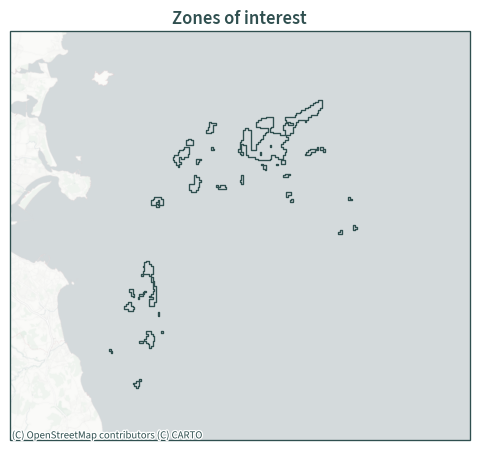

In [5]:
# height = 311 m, 500 m <= depth <= 2,000 m
zones, _ = fns.zones_of_interest(
    ds, CRS, {"height": 311, "min_depth": 500, "max_depth": 2000}
)

plot_zones_map(zones, extent, CRS)

## Generate potential salt cavern locations

In [6]:
def plot_map(dat_xr, dat_extent, dat_crs, cavern_df, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    cavern_df : cavern distribution
    var : variable
    stat : statistic (max / min / mean)
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(dat_crs))

    cbar_label = (
        f"{dat_xr[var].attrs['long_name']} [{dat_xr[var].attrs['units']}]"
    )

    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean {cbar_label}"

    plot_data[var].plot.contourf(
        cmap="jet",
        alpha=.65,
        robust=True,
        levels=15,
        cbar_kwargs={"label": cbar_label}
    )
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cavern_df.centroid.plot(
        ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
    )
    cx.add_basemap(ax, crs=dat_crs, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=.25, color="darkslategrey"
    )
    ax.add_artist(
        ScaleBar(
            1, box_alpha=0,  # font_properties={"size": "large"},
            location="lower right", color="darkslategrey"
        )
    )
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.05), markerscale=1.75)
    plt.title(None)
    plt.tight_layout()
    plt.show()

### Cavern calculations in a regular square grid

In [7]:
# diameter = 80 m, separation = 320 m
caverns = fns.generate_caverns_square_grid(extent, CRS, zones, 80)

Number of potential caverns: 305


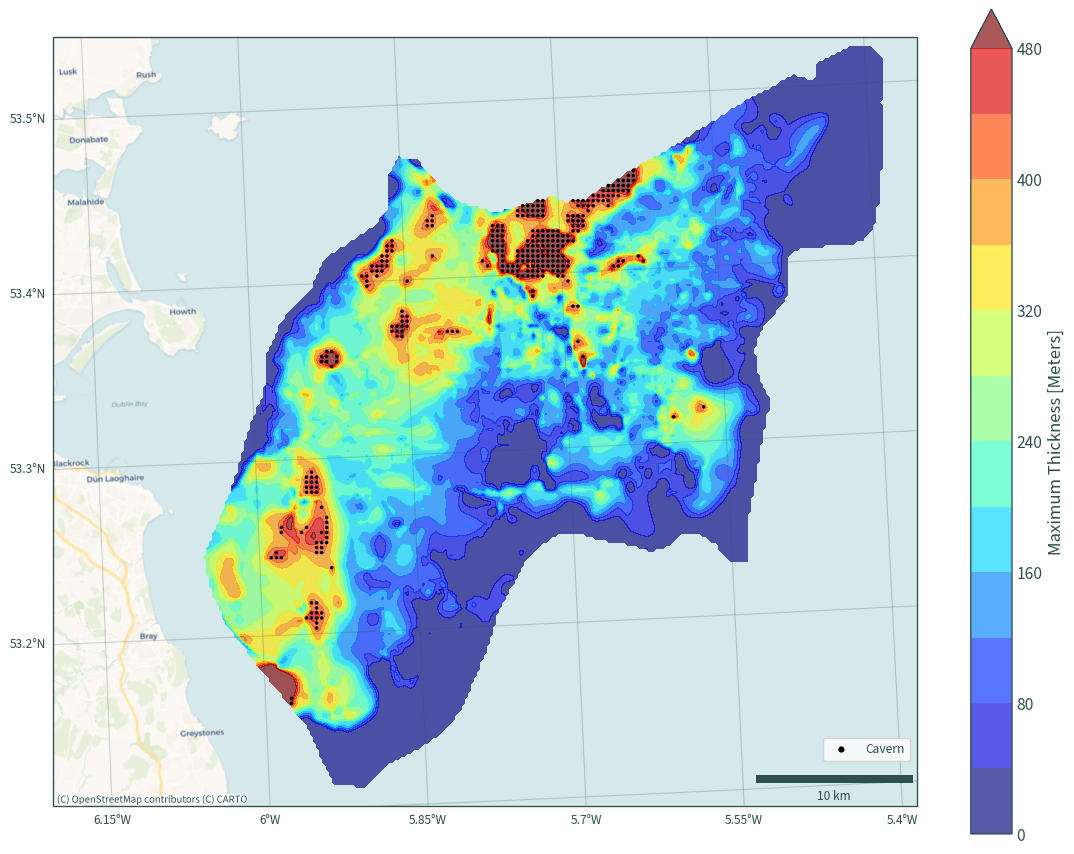

In [8]:
plot_map(ds, extent, CRS, caverns, "Thickness", "max")

### Cavern calculations in a regular hexagonal grid

In [9]:
caverns = fns.generate_caverns_hexagonal_grid(extent, CRS, zones, 80)

Number of potential caverns: 345


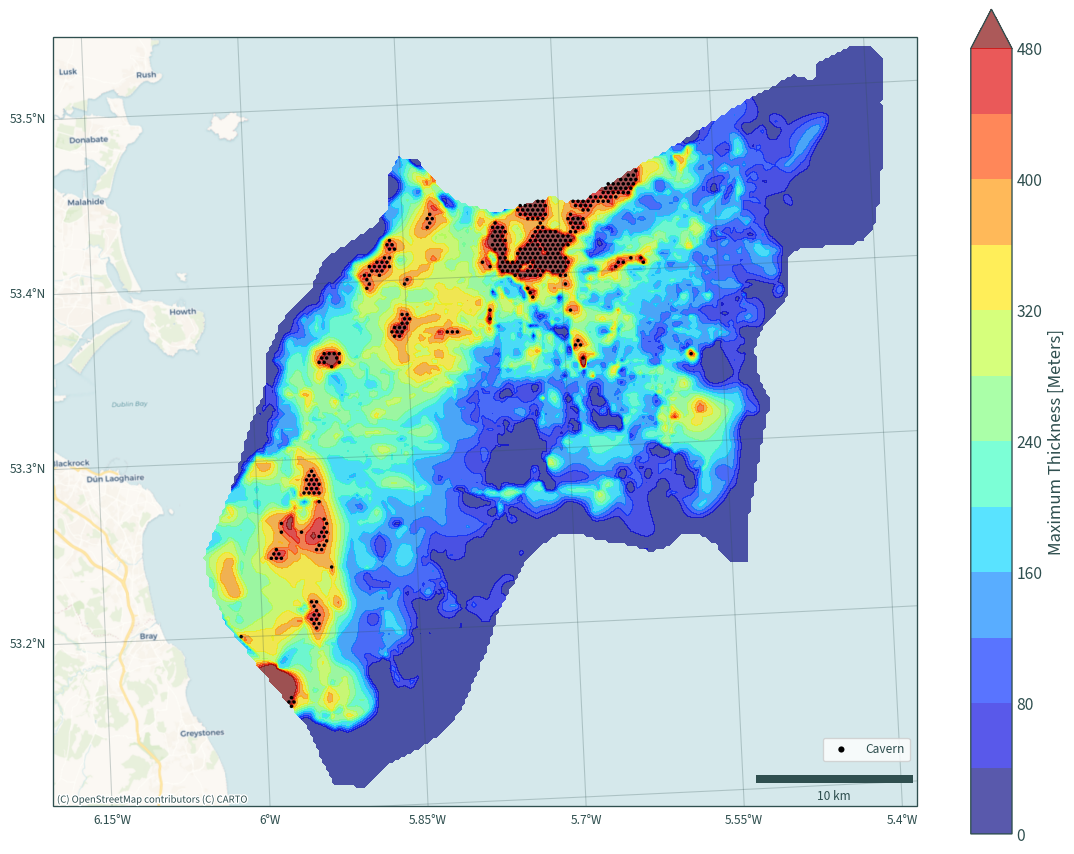

In [10]:
plot_map(ds, extent, CRS, caverns, "Thickness", "max")